In [1]:
import json
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
from names_dataset import NameDataset
from tqdm import tqdm
from spacy.tokenizer import Tokenizer
import spacy
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
nlp = spacy.load("en_core_web_sm")

### Pre-Note
Token labels are presented in BIO (Beginning, Inner, Outer) format. The PII type is prefixed with “B-” when it is the beginning of an entity. If the token is a continuation of an entity, it is prefixed with “I-”. Tokens that are not PII are labeled “O”.

**Model idea** Lets instead of using the predefined token space, we define a new one without BIO definition, but where we concat tokens that are part of the same entity. We can then afterwards use SpaCy tokenizer to reverse the changes we made and get the labels.

In [2]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [3]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [4]:
labels = df.labels.explode().reset_index(drop=True)
labels_vc = labels.value_counts()
labels_vc

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

In [5]:
# Create new tokens by concatinating items in the tokens list until a 0 label is found
# we do this for each row
new_labels_dict = {
    'O': 'O',
    'B-URL_PERSONAL': 'URL_PERSONAL',
    'I-URL_PERSONAL': 'URL_PERSONAL',
    'B-EMAIL': 'EMAIL',
    'I-EMAIL': 'EMAIL',
    'B-ID_NUM': 'ID_NUM',
    'I-ID_NUM': 'ID_NUM',
    'I-STREET_ADDRESS': 'STREET_ADDRESS',
    'B-STREET_ADDRESS': 'STREET_ADDRESS',
    'I-PHONE_NUM': 'PHONE_NUM',
    'B-PHONE_NUM': 'PHONE_NUM',
    'B-USERNAME': 'USERNAME',
    'I-USERNAME': 'USERNAME',
    'B-PHONE_NUM': 'PHONE_NUM',
    'I-PHONE_NUM': 'PHONE_NUM',
    'I-URL_PERSONAL': 'URL_PERSONAL',
    'B-URL_PERSONAL': 'URL_PERSONAL',
    'B-NAME_STUDENT': 'NAME_STUDENT',
    'I-NAME_STUDENT': 'NAME_STUDENT',
}

def create_new_tokens(row):
    tokens = row["tokens"]
    labels = row["labels"]
    new_tokens = []
    new_labels = []
    building_token, building_token_label = "", None
    for token, label in zip(tokens, labels):
        # If the token is in the new_labels_dict, we start building the new token until we find a 0 label
        if label in new_labels_dict and label != "O" and label != "I-NAME_STUDENT" and label != "B-NAME_STUDENT":
            building_token += token
            building_token_label = new_labels_dict[label]
        # Else the new token is not PII class so we append the building token and the token to the new tokens list
        else:
            if building_token:
                new_tokens.append(building_token)
                new_labels.append(building_token_label)
            
            new_tokens.append(token)
            new_labels.append(label)

            building_token = ""

    return new_tokens, new_labels

In [6]:
df[["new_tokens", "new_labels"]] = df.apply(create_new_tokens, axis=1, result_type="expand")

In [7]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels,new_tokens,new_labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...","[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[Diego, Estrada, \n\n, Design, Thinking, Assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[Reporting, process, \n\n, by, Gilberto, Gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT...","[Design, Thinking, for, Innovation, \n\n, Sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...","[Assignment, :, , Visualization, , Reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [8]:
tokens_exploded = df.tokens.explode().reset_index(drop=True)
labels_exploded = df.labels.explode().reset_index(drop=True)
labels_exploded.value_counts()

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

In [9]:
tokens_exploded[:20]

0         Design
1       Thinking
2            for
3     innovation
4      reflexion
5              -
6          Avril
7           2021
8              -
9       Nathalie
10         Sylla
11          \n\n
12     Challenge
13             &
14     selection
15          \n\n
16           The
17          tool
18             I
19           use
Name: tokens, dtype: object

In [10]:
ids = labels_exploded[labels_exploded == 'B-STREET_ADDRESS'].index
print(" ".join(tokens_exploded[ids[0]-15:ids[0]+15]))
print("-"*50)
print(" ".join(tokens_exploded[ids[1]-15:ids[1]+15]))

and next time I want to concentrate on them , too 

 Waseem Mabunda   591 Smith Centers Apt . 656 
 Joshuamouth , RI 95963 ( The Netherlands )
--------------------------------------------------
the business model , and got ourselves an   identity ( 1861 . Milano - 743 Erika Bypass Apt . 419 
 Andreahaven , IL 54207 ) looking forward to


In [11]:
ids = labels_exploded[labels_exploded == 'I-STREET_ADDRESS'].index
tokens_exploded[ids]

861200           Smith
861201         Centers
861202             Apt
861203               .
861204             656
861205              \n
861206     Joshuamouth
861207               ,
861208              RI
861209           95963
1445331          Erika
1445332         Bypass
1445333            Apt
1445334              .
1445335            419
1445336             \n
1445337    Andreahaven
1445338              ,
1445339             IL
1445340          54207
Name: tokens, dtype: object

In [12]:
new_tokens_exploded = df.new_tokens.explode().reset_index(drop=True)
new_labels_exploded = df.new_labels.explode().reset_index(drop=True)
new_labels_exploded.value_counts()

new_labels
O                 4989794
B-NAME_STUDENT       1365
I-NAME_STUDENT       1096
URL_PERSONAL          110
ID_NUM                 78
EMAIL                  39
USERNAME                6
PHONE_NUM               6
STREET_ADDRESS          2
Name: count, dtype: int64

In [13]:
ids = new_labels_exploded[new_labels_exploded == 'STREET_ADDRESS'].index
new_tokens_exploded[ids]

861183     591SmithCentersApt.656\nJoshuamouth,RI95963
1445304     743ErikaBypassApt.419\nAndreahaven,IL54207
Name: new_tokens, dtype: object

### ID_NUM

In [14]:
idx = new_labels_exploded[new_labels_exploded == "ID_NUM"].index
b_ids = new_tokens_exploded[idx]
b_ids.shape

(78,)

In [15]:
reg = r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
specific_id = b_ids.str.contains(reg)
ids_in_tokens = new_tokens_exploded.str.contains(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  73
Regex finding Ids in all tokens:  248

Accuracy Regex finding Ids in label specific:  0.9358974358974359
Error of missclassification in whole 4.967455156699174e-05


### EMAIL

In [16]:
idx = new_labels_exploded[new_labels_exploded == "EMAIL"].index
b_email = new_tokens_exploded[idx]
b_email.shape

(39,)

In [17]:
reg = r'[\w\.-]+@[\w\.-]+'
specific_id = b_email.str.match(reg)
ids_in_tokens = new_tokens_exploded.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  39
Regex finding Ids in all tokens:  49

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 9.814729946704014e-06


### URL_PERSONAL

In [18]:
idx = new_labels_exploded[new_labels_exploded == "URL_PERSONAL"].index
b_url = new_tokens_exploded[idx]
b_url.shape

(110,)

In [19]:
reg = r'https?://\S+|www\.\S+'
specific_id = b_url.str.match(reg)
ids_in_tokens = new_tokens_exploded.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  109
Regex finding Ids in all tokens:  327

Accuracy Regex finding Ids in label specific:  0.990909090909091
Error of missclassification in whole 6.54982998484125e-05


### PHONE_NUM

In [20]:
idx = new_labels_exploded[new_labels_exploded == "PHONE_NUM"].index
b_phone = new_tokens_exploded[idx]
b_phone.shape

(6,)

In [21]:
reg = r'\(?(\d{3})\)?[-. ]?(\d{3})[-. ]?(\d{4})(x\d{2,5})?'
specific_id = b_phone.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  6
Regex finding Ids in all tokens:  327

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 6.54982998484125e-05


## Model Definition
We will attempt to create the simplest model possible. The model will evaluate each token and pass it through a couple functions to evaluate it. If one of the functions returns true, the token will be considered a keyword. The model will then return the keyword and the index of the token in the input string.

### Model Functions
- **email** This function will use regex to identify if the token is an email address.
- **phone_num** This function will use regex to identify if the token is a phone number.
- **address** This function will use regex to identify if the token is an address.
- **username** This function will use a word embedding model to identify if the token is a common word and if not then we flag it as a username.
- **personal_id** This function will use regex to identify if the token is a personal id.


In [22]:
names = NameDataset()

**To do**
Maybe we could make some more features for capitalised words etc.

In [115]:
names.first_names.get("Learning")

In [120]:
import re

def tokenizer(text):
    # Remove excessive line breaks or spaces
    text = re.sub('(\r\n){2,}', ' ', text)
    
    # Convert the text to lowercase and split into tokens
    tokens = text.lower().split(" ")
    
    return tokens

class PiiModel:
    def __init__(self, text: str = None, names_dataset = None, tokens: list = None, dataframe: pd.DataFrame = None) -> None:
        self.text = text
        self.names = names_dataset
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.name_rank_threhsold = 1500
        self.country_threshold = 0.01
        self.feature_df = pd.DataFrame()
        self.input_df = dataframe
        pass
    
    def get_firstname(self, name: str) -> bool:
        found_name = self.names.first_names.get(name.capitalize())
        # we check if US exists found_name.country
        if not found_name:
            return False
        country = found_name["country"]
        if country.get("US", 0) > self.country_threshold and found_name["rank"].get("US", 1e6) < self.name_rank_threhsold:
            return True
        return False

    
    def get_lastname(self, lastname: str) -> bool:
        found_name = self.names.last_names.get(lastname.capitalize())
        # we check if the max country is higher than a threshold then we say it is a valid name
        if not found_name:
            return False
        country = found_name["country"]
        if country.get("US", 0) > self.country_threshold and found_name["rank"].get("US", 1e6) < self.name_rank_threhsold:
            return True
        return False
    
    def get_email_regex(self):
        return r'[\w\.-]+@[\w\.-]+'
    
    def get_phone_number_regex(self):
        return r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    
    def get_address_regex(self):
        return r'\d{1,5}\s\w.\s(\b\w*\b\s){1,2}\w*\.'
    
    def get_personal_id_regex(self):
        return r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
    
    def get_url_personal_regex(self):
        return r'https?://[\w\.-]+'
    
    def numb_percent(self, text: str) -> float:
        return sum(c.isdigit() for c in text) / len(text)
    
    def word_length(self, text: str) -> int:
        return len(text)
    
    def is_punctuationmark(self, text: str) -> bool:
        return text in [".", ",", "!", "?", ";", ":"]
    
    def stop_words(self, text: str) -> bool:
        return text in nlp.Defaults.stop_words
    
    def NER_ingest(self, text: str):
        return nlp(text)
    
    def capitalize(self, text: str) -> bool:
        return text[0].strip().isupper()

    def build_features(self, text: str = "", tokens: list = None) -> list[tuple[int, str]]:
        token_indices = self.tokens
        if not self.tokens and text != "":
            token_indices = self.tokenizer(text)
            self.tokens = token_indices
        if tokens:
            token_indices = tokens
        elif self.input_df is not None:
            token_indices = self.input_df["tokens"]
        self.feature_df["token"] = token_indices
        # Computing Features
        self.feature_df['first_name'] = self.feature_df['token'].apply(self.get_firstname)
        self.feature_df['last_name'] = self.feature_df['token'].apply(self.get_lastname)
        self.feature_df['email'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_email_regex(), x)))
        self.feature_df['phone_number'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_phone_number_regex(), x)))
        self.feature_df['address'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_address_regex(), x)))
        self.feature_df['personal_id'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_personal_id_regex(), x)))
        self.feature_df['url'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_url_personal_regex(), x)))
        self.feature_df['capitalized'] = self.feature_df['token'].apply(lambda x: self.capitalize(x))
        self.feature_df['r_neighboured_capitalized'] = self.feature_df['capitalized'].shift(-1).fillna(False)
        self.feature_df['l_neighboured_capitalized'] = self.feature_df['capitalized'].shift(1).fillna(False)
        self.feature_df['numb_percent'] = self.feature_df['token'].apply(self.numb_percent)
        self.feature_df['r_neighboured_numb_percent'] = self.feature_df['numb_percent'].shift(-1).fillna(False)
        self.feature_df['l_neighboured_numb_percent'] = self.feature_df['numb_percent'].shift(1).fillna(False)
        self.feature_df['word_length'] = self.feature_df['token'].apply(self.word_length)
        self.feature_df['norm_index'] = self.feature_df.index / len(self.feature_df)
        self.feature_df['is_punctuation'] = self.feature_df['token'].apply(self.is_punctuationmark)
        self.feature_df['r_neighboured_punctuation'] = self.feature_df['is_punctuation'].shift(-1).fillna(False)
        self.feature_df['l_neighboured_punctuation'] = self.feature_df['is_punctuation'].shift(1).fillna(False)
        self.feature_df['stop_word'] = self.feature_df['token'].apply(self.stop_words)
        if self.input_df is not None:
            self.feature_df["text_index"] = self.input_df.text_index

        return None


In [121]:
tokens = df.iloc[0].new_tokens
model = PiiModel(text=tokens, names_dataset=names)
pii_indexes = model.build_features(tokens=tokens)
model.feature_df['labels'] = df.iloc[0].new_labels
model.feature_df['labels'] = model.feature_df['labels'].astype('category').cat.codes
model.feature_df.head(15)

,token,first_name,last_name,email,phone_number,address,personal_id,url,capitalized,r_neighboured_capitalized,l_neighboured_capitalized,numb_percent,r_neighboured_numb_percent,l_neighboured_numb_percent,word_length,is_punctuation,r_neighboured_punctuation,l_neighboured_punctuation,stop_word,labels
0,Design,False,False,False,False,False,False,False,True,True,False,0.0,0.0,False,6,False,False,False,False,2
1,Thinking,False,False,False,False,False,False,False,True,False,True,0.0,0.0,0.0,8,False,False,False,False,2
2,for,False,False,False,False,False,False,False,False,False,True,0.0,0.0,0.0,3,False,False,False,True,2
3,innovation,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,10,False,False,False,False,2
4,reflexion,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,9,False,False,False,False,2
5,-,False,False,False,False,False,False,False,False,True,False,0.0,0.0,0.0,1,False,False,False,False,2
6,Avril,False,False,False,False,False,False,False,True,False,False,0.0,1.0,0.0,5,False,False,False,False,2
7,2021,False,False,False,False,False,False,False,False,False,True,1.0,0.0,0.0,4,False,False,False,False,2
8,-,False,False,False,False,False,False,False,False,True,False,0.0,0.0,1.0,1,False,False,False,False,2
9,Nathalie,True,False,False,False,False,False,False,True,True,False,0.0,0.0,0.0,8,False,False,False,False,0


## Data building


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.new_tokens, df.new_labels, test_size=0.33, random_state=42)

In [123]:
dfs_train = []

for i in tqdm(range(X_train.shape[0])):
    tokens = X_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    pii_indexes = model.build_features(tokens=tokens)
    model.feature_df['labels'] = y_train.iloc[i]
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_train.append(model.feature_df)

X_train = pd.concat(dfs_train, axis=0)
X_train.fillna(0, inplace=True)


  0%|          | 0/4560 [00:00<?, ?it/s]

100%|██████████| 4560/4560 [00:27<00:00, 164.35it/s]


In [124]:
dfs_test = []

for i in tqdm(range(X_test.shape[0])):
    tokens = X_test.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    pii_indexes = model.build_features(tokens=tokens)
    model.feature_df['labels'] = y_test.iloc[i]
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_test.append(model.feature_df)

X_test = pd.concat(dfs_test, axis=0)
X_test.fillna(0, inplace=True)


  0%|          | 0/2247 [00:00<?, ?it/s]

100%|██████████| 2247/2247 [00:13<00:00, 170.26it/s]


## Modelling
We will use the XGBoost model to classify the tokens.

In [125]:
model = RandomForestClassifier(verbose=2, n_jobs=-1)
model.fit(X_train.drop(columns=["token", "labels"]), y_train.explode())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100

building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


RandomForestClassifier(n_jobs=-1, verbose=2)

In [126]:
model.score(X_test.drop(columns=["token", "labels"]), y_test.explode())

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished


0.9994599801770999

In [127]:
predictions = model.predict(X_test.drop(columns=["token", "labels"]))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


In [128]:
pd.Series(predictions).value_counts()

O                 1653455
I-NAME_STUDENT         84
URL_PERSONAL           34
B-NAME_STUDENT         32
ID_NUM                 28
EMAIL                   9
STREET_ADDRESS          1
Name: count, dtype: int64

In [129]:
pd.Series(y_test.explode()).value_counts()

new_labels
O                 1652726
B-NAME_STUDENT        454
I-NAME_STUDENT        379
URL_PERSONAL           43
ID_NUM                 24
EMAIL                   9
PHONE_NUM               6
STREET_ADDRESS          1
USERNAME                1
Name: count, dtype: int64

In [130]:
df_results = pd.DataFrame({"predictions": pd.Series(predictions).reset_index(drop=True), 
                           "labels": y_test.explode().reset_index(drop=True), 
                           "tokens": X_test.token.explode().reset_index(drop=True)})
df_results.head()

,predictions,labels,tokens
0,O,O,Assignment
1,O,O,:
2,O,O,Mindmapping
3,O,O,\n\n
4,O,O,Challenge


In [131]:
accuracy = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O")) & 
    (df_results['predictions'] == df_results['labels'])
].shape[0] / df_results[(df_results['predictions'] != "O") | (df_results['labels'] != "O")].shape[0]


In [132]:
accuracy

0.10521042084168336

In [133]:
df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))][["predictions", "labels"]].value_counts()

predictions     labels        
O               B-NAME_STUDENT    435
                I-NAME_STUDENT    338
I-NAME_STUDENT  O                  42
                I-NAME_STUDENT     41
O               URL_PERSONAL       27
ID_NUM          ID_NUM             20
URL_PERSONAL    O                  18
B-NAME_STUDENT  B-NAME_STUDENT     18
URL_PERSONAL    URL_PERSONAL       16
B-NAME_STUDENT  O                  14
EMAIL           EMAIL               9
ID_NUM          O                   7
O               PHONE_NUM           5
                ID_NUM              4
ID_NUM          PHONE_NUM           1
I-NAME_STUDENT  B-NAME_STUDENT      1
O               USERNAME            1
STREET_ADDRESS  STREET_ADDRESS      1
Name: count, dtype: int64

In [134]:
df_results[((df_results['predictions'] == "B-NAME_STUDENT") & (df_results['labels'] == "O"))]

,predictions,labels,tokens
318406,B-NAME_STUDENT,O,Alicia
339961,B-NAME_STUDENT,O,Harry
432323,B-NAME_STUDENT,O,Sandra
696084,B-NAME_STUDENT,O,Stefan
712122,B-NAME_STUDENT,O,Angela
719962,B-NAME_STUDENT,O,Amelia
869895,B-NAME_STUDENT,O,Chris
959952,B-NAME_STUDENT,O,Jocelyn
962093,B-NAME_STUDENT,O,Mariah
1171783,B-NAME_STUDENT,O,German


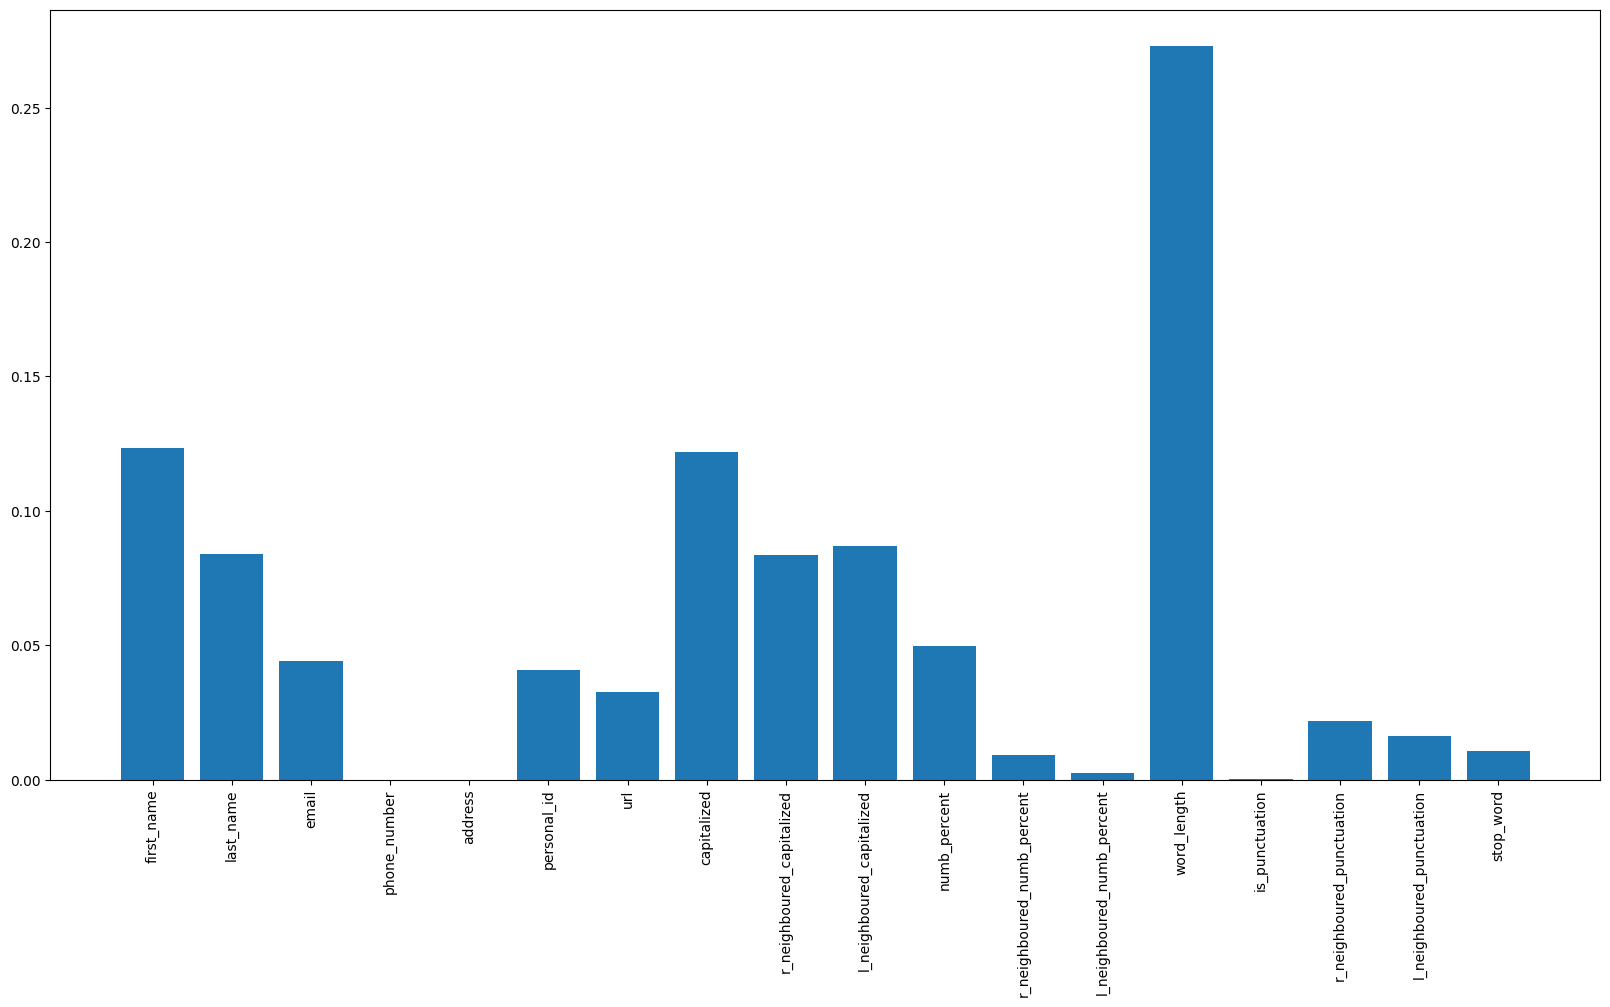

In [135]:
# print feature importance
importances = model.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(X_train.drop(columns=["token", "labels"]).columns, importances)
plt.xticks(rotation=90)
plt.show();